# Geologische Fernerkundungs-Methoden am Beispiel des Siebengebirges 

Am Beispiel des Siebengebirges nahe Bonn möchte ich verschiedene geologische Ansätze testen, inwiefern sich Sentinel-2 Daten (evtl. ergänzt mit anderen Satellitendaten wie Landsat) für die geol. Beschreibung des Gebiets eignen. 

Zuerst laden wir ein aktuelles Sentinel-2 Bild ohne nennenswerte Wolkenbedeckung (Sep. 2025) vom Copernicus Dataspace herunter. Aus dem S2-Datenverarbeitungsskript für Uruguay nehmen wir den Code, um die Nodata- Bereiche herauszuschneiden (bei häufiger Benutzung ggfs. mal als Funktion umschreiben). In der Python-Konsole von QGIS ausführbar.

In [10]:
# allgemeine importbefehle für das projekt 

import rasterio 
from rasterio.windows import from_bounds
import numpy as np
import pyproj
import matplotlib.pyplot as plt

In [ ]:
from qgis.core import QgsRasterLayer, QgsProject 
import processing 

testbild_path = r"C:\Users\Daniel Koch\Desktop\Fernerkundung\Daten\Siebengebirge\S2A_MSIL2A_20250907T103031_N0511_R108_T31UGS_20250907T142815.SAFE\GRANULE\L2A_T31UGS_A053330_20250907T103505\IMG_DATA\R10m\T31UGS_20250907T103031_TCI_10m.jp2"

lyr = QgsRasterLayer(testbild_path, os.path.basename(testbild_path))

cut_path = os.path.splitext(testbild_path)[0] + "_cut.tif"

params = {
    'INPUT': testbild_path,
    'TARGET_CRS': None,
    'NODATA': 0,              
    'COPY_SUBDATASETS': False,
    'OPTIONS': 'COMPRESS=ZSTD|PREDICTOR=2|TILED=YES|ZSTD_LEVEL=9', 
    # um dateigroeße zu senken. Funktioniert nur für das TCI!
    'DATA_TYPE': 0,
    'OUTPUT': cut_path
}
processing.run("gdal:translate", params)

QgsProject.instance().addMapLayer(QgsRasterLayer(cut_path, os.path.basename(cut_path)))

print(f"Gespeichert: {cut_path}")

Diesen Schritt führen wir für das True Color Image (TCI) sowie für die jeweiligen Bänder aus, die wir benötigen

### Geologie des Siebengebirges 

- Vorausgehend: Im Devon und Unterkarbon (Paläozoikum) werden Sedimente abgelagert und im Rahmen der variszischen Gebirgsbildung zum Rheinischen Schiefergebirge aufgeschoben.
- Absinken der Kölner Bucht im Paläozan 
- Entstehung im Tertiär (vor ca 25 Ma), vulkanisches Gebiet das auf dem Rheinischen Schiefergebirge aufsitzt
- Niederrheinische Bucht sinkt seit 40 Ma als keilförmige Scholle
- Trachyte, Basalte, Latite und Phonolithe (Lava drang in den Tuff ein, kühlte ab und erstarrte). Zentrum der Ausbrüche im Mirbesbachtal zwischen Petersberg und Drachenfels 
- Herausforderung in der Überlagerung von Vegetation (NDVI-Threshold von z.B. >0.2 einbauen) und böden sowie anthopogenem Einfluss
- Heutige Hebung des Rheinischen Schiefergebirges um 1mm/a (begann vor 400ka sich erneut zu heben, wodurch sich die Erosion beschleunigte und der Tuff erodiert wurde -> Übrig blieben Drachenfels, Ölberg etc.) Der Rhein schnitt sich in den Untergrund ein, wodurch die vorhandenen Quellkuppen aus dem vorher vorhandenen Tuffmantel hervorkamen (Entstehung des Ur-Rheins im Miozän/Pliozän ca. vor 5 Ma).
- Hebung und Erosion der Flusstäler während der pleistozänen Glaziale (Hauptterasse Cromer/Elster-Eiszeit, Mittelterrasse Elster- bis Saale-Eiszeit, Niederterrasse Weichsel-Eiszeit)
- 13 höchste Gipfel: Dollendorfer Hardt, Weilberg, Stenzelberg, Petersberg, Rosenau, Ölberg, Nonnenstromberg, Hirschberg, Wolkenburg, Drachenfels, Großer Breiberg, Löwenburg, Lohrberg

### Vegetation und Ökologie

- Sowohl nährstoffarme- wie reiche, basische und saure, lehmige, felsige und kiesige Pflanzenarten
- Durch vulkanische Geschichte verschiedene SiO2-Bedingungen der jeweiligen Berge
- basische Böden: Bingelkraut, Küchenschelle, Goldnessel, Waldmeister, Einblütiges Perlgras
- saure Böden: Hainsimse, Besenheide, Stechpalme
- bis 150m Eichenwälder, bis 250m Eichen-Hainbuchen, ab 250m Rotbuchen, ab 350m vorherrschenden Buchen

- wärmeliebende, mediterrane Arten auf schwarzem Schiefer und Basalt (als Wärmespeicher) 

Quellen: 
- https://www.naturpark7gebirge.de/der-naturpark/geologie
- https://www.gd.nrw.de/ge_ev_geologie-erleben_siebengebirge
- Schwarz C (2014) Die Geschichte der geologischen Erforschung des Siebengebirges 

### Iron Oxide Index

Verwitterung in Form von Eisenoxide (Hämatit, Goethit) können wir mit dem Iron Oxide Index (B4/B2) testen. 

1. B4 und B2 aus heruntergeladener S2-Datei im QGIS einladen bzw. direkt mit oben genanntem Code die nodata-Bereiche wegschneiden. OPTIONS muss hier für die Bänder geändert werden!
   
'OPTIONS': 'QUALITY=10|REVERSIBLE=NO|YCBCR=NO|BLOCKXSIZE=512|BLOCKYSIZE=512|RESOLUTIONS=5|LAYERS=8',


2. Iron Oxide Index (IOI) im QGIS-Rasterrechner berechnen (alternativ mit entsprechendem PyQGIS-Code)

Ich habe die IOI Farbskala von 0,9 bis 1,2 skaliert, wobei Agrarflächen tendenziell höhere Werte aufweisen als bspw. Wald. 

### Visualisieren 

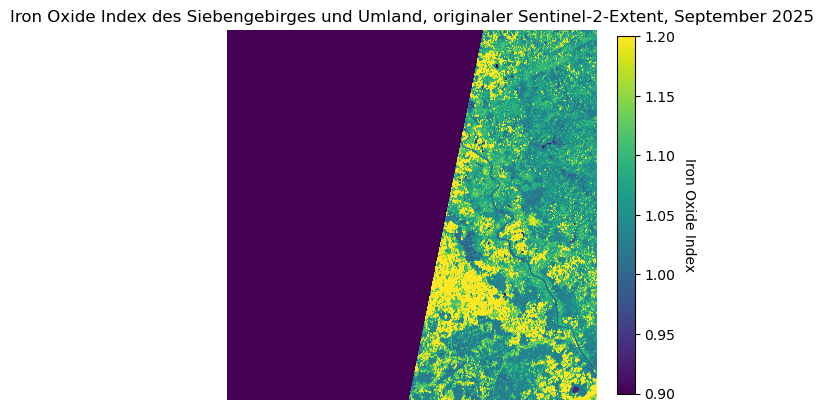

In [16]:
ioi_raster_path = r"C:\Users\Daniel Koch\Desktop\Fernerkundung\Daten\Siebengebirge\S2A_MSIL2A_20250907T103031_N0511_R108_T31UGS_20250907T142815.SAFE\IronIndex_Siebengebirge_Sep25.tif"

with rasterio.open(ioi_raster_path) as src:
    arr = src.read(1)  

im = plt.imshow(arr,  vmin=0.9, vmax=1.2)
plt.title("Iron Oxide Index des Siebengebirges und Umland, originaler Sentinel-2-Extent, September 2025")
plt.axis('off')

cbar = plt.colorbar(im, fraction=0.036, pad=0.04)
cbar.set_label("Iron Oxide Index", rotation=270, labelpad=15)

plt.show()

In [12]:
# RASTER EXTENT TESTEN 
with rasterio.open(ioi_raster_path) as src:
    print("Raster-KBS:", src.crs) 
    print("Raster- Extent:", src.bounds)

Raster-KBS: PROJCS["WGS 84 / UTM zone 31N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Raster- Extent: BoundingBox(left=699960.0, bottom=5590200.0, right=809760.0, top=5700000.0)


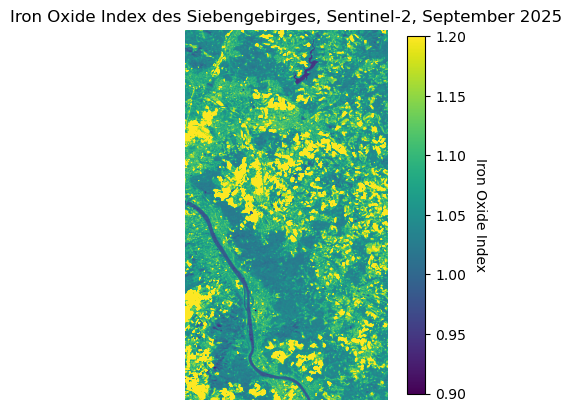

In [17]:
# Bbox unseres relevanten ausschnittes ´, KBS PRUEFEN!
bbox = (792349, 5609745, 820233, 5641442)

with rasterio.open(ioi_raster_path) as src:
    window = from_bounds(*bbox, transform=src.transform)
    arr = src.read(1, window=window)
    
im = plt.imshow(arr,  vmin=0.9, vmax=1.2)
plt.title("Iron Oxide Index des Siebengebirges, Sentinel-2, September 2025")
plt.axis('off')

cbar = plt.colorbar(im, fraction=0.036, pad=0.04)
cbar.set_label("Iron Oxide Index", rotation=270, labelpad=15)

plt.show()

Außerdem: 
- Fels und Bodenpixel extrahieren
- ferrous iron index (B11/B4)
- Clay index (B11/B12)
- mit GK25 des siebengebirges abgleichen?
- SWIR für Tonminerale 
- DGM verfügbar? 